In [1]:
# !pip install tensorflow_addons

In [2]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [3]:
# !unzip gdrive/My\ Drive/archive.zip > /dev/null

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import backend
from keras import datasets, layers, models, initializers, activations
from keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate
from functools import reduce


from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2 as cv
import os

from imutils import paths
import pathlib
import time
import glob
from natsort import natsorted
import tarfile
import tqdm


Tensorflow version 2.10.0
GPU is ON


In [5]:
output_size = (256, 256)
num_classes = 23
colors = np.array([(0, 0, 0),
                   (70, 70, 70),
                   (100, 40, 40),
                   (55, 90, 80),
                   (220, 20, 60),
                   (153, 153, 153),
                   (157, 234, 50),
                   (128, 64, 128),
                   (244, 35, 232),
                   (107, 142, 35),
                   (0, 0, 142),
                   (102, 102, 156),
                   (220, 220, 0),
                   (70, 130, 180),
                   (81, 0, 81),
                   (150, 100, 100),
                   (230, 150, 140),
                   (180, 165, 180),
                   (250, 170, 30), 
                   (110, 190, 160),
                   (170, 120, 50),
                   (45, 60, 150),
                   (145, 170, 100)])

In [6]:
def load_image(image_path):

  image = cv.imread(image_path)
  image = cv.resize(image, output_size)
  image = image/255.
  image = image.astype(np.float32)

  return image
  
def load_mask(mask_path):
  
  mask = cv.imread(mask_path)
  mask = cv.resize(mask, output_size)
  mask = mask[:,:,2]
  mask = mask.astype(np.int32)

  return mask
  

In [7]:
def rectifying (image_path, mask_path):
  image = load_image(image_path)
  mask = load_mask(mask_path)
  mask = tf.one_hot(mask, num_classes, dtype =  tf.int32)
  image.reshape([256,256, 3])
  tf.reshape(mask, [256,256, num_classes])
  return image, mask

In [8]:
images_path = sorted(glob.glob('./dataA/dataA/CameraRGB/*.png'))
masks_path = sorted(glob.glob('./dataA/dataA/CameraSeg/*.png'))

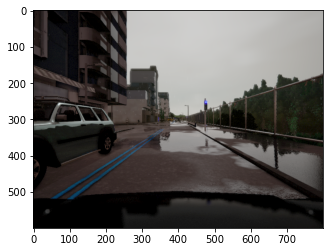

In [9]:
image = cv.imread(images_path[0])
plt.imshow(image)

./dataA/dataA/CameraSeg\02_00_000.png


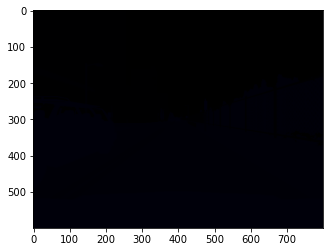

In [10]:
mask =cv.imread(masks_path[0])
plt.imshow(mask)
print(masks_path[0])

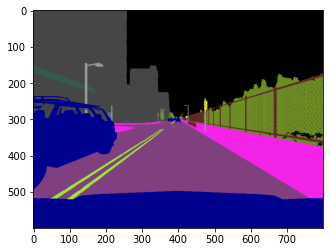

In [11]:
plt.imshow(colors[mask[:,:,2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


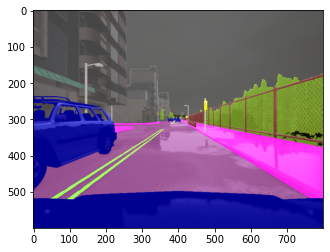

In [12]:
plt.imshow(cv.addWeighted(image.astype(np.int32), 0.5,colors[mask[:,:,2]].astype(np.int32), 1.,0))

In [13]:
from tqdm import tqdm
X_train, y_train = [], []
for x, y in tqdm(zip(images_path[:100], masks_path[:100])):
  x,y = rectifying (x, y)
  X_train.append(x)
  y_train.append(y)
X_train, y_train = np.array(X_train),np.array(y_train)

X_test, y_test = [], []
for x, y in tqdm(zip(images_path[200:215], masks_path[200:215])):
  x,y = rectifying (x, y)
  X_test.append(x)
  y_test.append(y)
X_test, y_test = np.array(X_test),np.array(y_test)


100it [00:06, 16.05it/s]
15it [00:00, 66.06it/s]


In [14]:

############ Backbone EfficientNet-B7 ############ 

from keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6
from _EfficientNet_B7 import EfficientNetB7 

#EfficientNet0, EfficientNet1, EfficientNet2, EfficientNet3, EfficientNet4, EfficientNet5, EfficientNet6, EfficientNet7
w_bifpns = [64, 88, 112, 160, 224, 288, 384, 384]
d_bifpns = [3, 4, 5, 6, 7, 7, 8, 8]
d_heads = [3, 3, 3, 4, 4, 4, 5, 5]
image_sizes = [256, 640, 768, 896, 1024, 1280, 1280, 1536]
backbones = [EfficientNetB0, EfficientNetB1, EfficientNetB2,
             EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7]

MOMENTUM = 0.9998
EPSILON = 1e-4

def get_efnet(w_bifpns, d_bifpns, d_heads,image_sizes, backbones,phi):
    input_size = image_sizes[phi]
    input_shape = (input_size, input_size, 3)
    image_input = layers.Input(input_shape)
    w_bifpn = w_bifpns[phi]
    d_bifpn = d_bifpns[phi]
    w_head = w_bifpn
    d_head = d_heads[phi]
    backbone_cls = backbones[phi]
    encoder = backbone_cls(input_tensor=image_input)
    i=0
    while False:
        s1 = encoder.get_layer(str("input_"+str(i))).output       ## 1536
        
    s2 = encoder.get_layer("block2a_expand_activation").output    ## 768
    s3 = encoder.get_layer("block3a_expand_activation").output    ## 384
    s4 = encoder.get_layer("block4a_expand_activation").output    ## 192
    s5 = encoder.get_layer("block5a_expand_activation").output    ## 96
#     s6 = encoder.get_layer("block6a_expand_activation").output  ## 96
    s6 = encoder.get_layer("block6a_bn").output                   ## 48
    s7 = encoder.get_layer("block7a_expand_activation").output    ## 48
    fpn_features = (s3,s4,s5,s6,s7)
    return image_input, w_bifpn, d_bifpn, w_head,  d_head, fpn_features

Tensorflow version 2.10.0
GPU is ON


In [15]:
class wBiFPNAdd(layers.Layer):
    def __init__(self, epsilon=1e-4, **kwargs):
        super(wBiFPNAdd, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        num_in = len(input_shape)
        self.w = self.add_weight(name=self.name,
                                 shape=(num_in,),
                                 initializer=initializers.constant(1 / num_in),
                                 trainable=True,
                                 dtype=tf.float32)

    def call(self, inputs, **kwargs):
        w = activations.relu(self.w)
        x = tf.reduce_sum([w[i] * inputs[i] for i in range(len(inputs))], axis=0)
        x = x / (tf.reduce_sum(w) + self.epsilon)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0]

    def get_config(self):
        config = super(wBiFPNAdd, self).get_config()
        config.update({
            'epsilon': self.epsilon
        })
        return config

## in - input node (feature from 3-7 levls of Backbone | 2d part of layer)
class input_node():
    def get_p3_inp_node(feature, num_channels, id):
        P3_in = feature
        P3_in = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                              name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/conv2d')(P3_in)
        P3_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                          name=f'fpn_cells/cell_{id}/fnode3/resample_0_0_8/bn')(P3_in)
        return P3_in
    def get_p4_inp_node(feature, num_channels, id):
        P4_in = feature
        P4_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/conv2d')(P4_in)
        P4_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode2/resample_0_1_7/bn')(P4_in_1)
        P4_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/conv2d')(P4_in)
        P4_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode4/resample_0_1_9/bn')(P4_in_2)
        return P4_in_1, P4_in_2
    def get_p5_inp_node(feature, num_channels, id):
        P5_in = feature
        P5_in_1 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/conv2d')(P5_in)
        P5_in_1 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode1/resample_0_2_6/bn')(P5_in_1)
        P5_in_2 = layers.Conv2D(num_channels, kernel_size=1, padding='same',
                                name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/conv2d')(P5_in)
        P5_in_2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON,
                                            name=f'fpn_cells/cell_{id}/fnode5/resample_0_2_10/bn')(P5_in_2)
        return P5_in_1, P5_in_2
    def get_p6_inp_node(feature, num_channels, id):
        P6_in = feature
        P6_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p6/conv2d')(P6_in)
        P6_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p6/bn')(P6_in)
        # P6_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P6_in)
        return P6_in
    def get_p7_inp_node(feature, num_channels, id):
        P7_in = feature
        P7_in = layers.Conv2D(num_channels, kernel_size=1, padding='same', name='resample_p7/conv2d')(P7_in)
        P7_in = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name='resample_p7/bn')(P7_in)
        P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p6/maxpool')(P7_in)
        return P7_in

## td - top-down node (feature on the top-down pathway | 2d part of layer)
class top_down_node():
    def get_p6_td_node(feature, upsample_block, num_channels, id):
        P6_in = feature
        P7_U = upsample_block
        P6_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode0/add')([P6_in, P7_U])
        P6_td = layers.Activation(lambda x: tf.nn.swish(x))(P6_td)
        P6_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode0/op_after_combine5')(P6_td)
        return P6_td

    def get_p5_td_node(feature, upsample_block, num_channels, id):
        P5_in_1 = feature
        P6_U = upsample_block
        P5_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode1/add')([P5_in_1, P6_U])
        P5_td = layers.Activation(lambda x: tf.nn.swish(x))(P5_td)
        P5_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode1/op_after_combine6')(P5_td)   
        return P5_td
    
    def get_p4_td_node(feature, upsample_block, num_channels, id):
        P4_in_1 = feature
        P5_U = upsample_block
        P4_td = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode2/add')([P4_in_1, P5_U])
        P4_td = layers.Activation(lambda x: tf.nn.swish(x))(P4_td)
        P4_td = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                   name=f'fpn_cells/cell_{id}/fnode2/op_after_combine7')(P4_td)
        return P4_td
## out - output node (feature on the bottom-up pathway | 3d part of layer)
class output_node():
    def get_p3_out_node(feature, upsample_block, num_channels, id):
        P3_in = feature
        P4_U = upsample_block
        P3_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode3/add')([P3_in, P4_U])
        P3_out = layers.Activation(lambda x: tf.nn.swish(x))(P3_out)
        P3_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode3/op_after_combine8')(P3_out)
        return P3_out

    def get_p4_out_node(feature, top_down_node, downsample_block, num_channels, id):
        P4_in_2 = feature
        P4_td = top_down_node
        P3_D = downsample_block
        P4_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode4/add')([P4_in_2, P4_td, P3_D])
        P4_out = layers.Activation(lambda x: tf.nn.swish(x))(P4_out)
        P4_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode4/op_after_combine9')(P4_out)
        return P4_out
    
    def get_p5_out_node(feature, top_down_node, downsample_block, num_channels, id):
        P5_in_2 = feature
        P5_td = top_down_node
        P4_D = downsample_block
        P5_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode5/add')([P5_in_2, P5_td, P4_D])
        P5_out = layers.Activation(lambda x: tf.nn.swish(x))(P5_out)
        P5_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode5/op_after_combine10')(P5_out)
        return P5_out
    
    def get_p6_out_node(feature, top_down_node, downsample_block, num_channels, id):
        P6_in = feature
        P6_td = top_down_node
        P5_D = downsample_block
        P6_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode6/add')([P6_in, P6_td, P5_D])
        P6_out = layers.Activation(lambda x: tf.nn.swish(x))(P6_out)
        P6_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode6/op_after_combine11')(P6_out)
        return P6_out
    
    def get_p7_out_node(feature, downsample_block, num_channels, id):
        P7_in = feature
        P6_D = downsample_block
        P7_out = wBiFPNAdd(name=f'fpn_cells/cell_{id}/fnode7/add')([P7_in, P6_D])
        P7_out = layers.Activation(lambda x: tf.nn.swish(x))(P7_out)
        P7_out = SeparableConvBlock(num_channels=num_channels, kernel_size=3, strides=1,
                                    name=f'fpn_cells/cell_{id}/fnode7/op_after_combine12')(P7_out)
        return P7_out

def SeparableConvBlock(num_channels, kernel_size, strides, name, freeze_bn=False):
    f1 = layers.SeparableConv2D(num_channels, kernel_size=kernel_size, strides=strides, padding='same',
                                use_bias=True, name=f'{name}/conv')
    f2 = layers.BatchNormalization(momentum=MOMENTUM, epsilon=EPSILON, name=f'{name}/bn')
    return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), (f1, f2))

def build_wBiFPN(features, num_channels, id, freeze_bn=False):
    if id == 0:
        C1, C2, C3, C4, C5 = features

    #Get input node
        P3_in = input_node.get_p3_inp_node(C1, num_channels, id)
        P4_in_1, P4_in_2 = input_node.get_p4_inp_node(C2, num_channels, id)
        P5_in_1, P5_in_2 = input_node.get_p5_inp_node(C3, num_channels, id)
        P6_in = input_node.get_p6_inp_node(C4, num_channels, id)
        P7_in = input_node.get_p7_inp_node(C5, num_channels, id)
        # P7_in = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='resample_p7/maxpool')(C5)

    #Get top-down node
        #upsampling
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = top_down_node.get_p6_td_node(P6_in, P7_U, num_channels, id)
        #upsampling
        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = top_down_node.get_p5_td_node(P5_in_1, P6_U, num_channels, id)
        #upsampling
        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = top_down_node.get_p4_td_node(P4_in_1, P5_U, num_channels, id)
        
    #Get output node
        #upsampling
        P4_U = layers.UpSampling2D()(P4_td)    
        P3_out = output_node.get_p3_out_node(P3_in, P4_U, num_channels, id)
        #downsampling
        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = output_node.get_p4_out_node(P4_in_2, P4_td, P3_D, num_channels, id)
        #downsampling
        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = output_node.get_p5_out_node(P5_in_2, P5_td, P4_D, num_channels, id)
        #downsampling
        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = output_node.get_p6_out_node(P6_in, P6_td, P5_D, num_channels, id)
        #downsampling
        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = output_node.get_p7_out_node(P7_in, P6_D, num_channels, id)
    else:
        P3_in, P4_in, P5_in, P6_in, P7_in = features
    
    #Get top-down node
        P7_U = layers.UpSampling2D()(P7_in)
        P6_td = top_down_node.get_p6_td_node(P6_in, P7_U, num_channels, id)

        P6_U = layers.UpSampling2D()(P6_td)
        P5_td = top_down_node.get_p5_td_node(P5_in, P6_U, num_channels, id)

        P5_U = layers.UpSampling2D()(P5_td)
        P4_td = top_down_node.get_p4_td_node(P4_in, P5_U, num_channels, id)
 
    #Get output node  
        P4_U = layers.UpSampling2D()(P4_td)
        P3_out = output_node.get_p3_out_node(P3_in, P4_U, num_channels, id)

        P3_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P3_out)
        P4_out = output_node.get_p4_out_node(P4_in, P4_td, P3_D, num_channels, id)
     
        P4_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P4_out)
        P5_out = output_node.get_p5_out_node(P5_in, P5_td, P4_D, num_channels, id)
       
        P5_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P5_out)
        P6_out = output_node.get_p6_out_node(P6_in, P6_td, P5_D, num_channels, id)
        
        P6_D = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(P6_out)
        P7_out = output_node.get_p7_out_node(P7_in, P6_D, num_channels, id)
    return P3_out, P4_td, P5_td, P6_td, P7_out


In [16]:
class UNet ():
    def decoder_block(inputs, skip, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
        x = Concatenate()([x, skip])
        x = UNet.downsample_block(x, num_filters)
        return x

    def downsample_block(inputs, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("LeakyReLU")(x)

        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("LeakyReLU")(x)

        return x

    def build_unet(fpn_features, num_classes):

        b1 = fpn_features[4]
        b1 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(b1) ## 16
        d1 = UNet.decoder_block(b1, fpn_features[4], 384)
        d2 = UNet.decoder_block(d1, fpn_features[3], 192)
        d3 = UNet.decoder_block(d2, fpn_features[2], 96)
        d4 = UNet.decoder_block(d3, fpn_features[1], 48)
        d5 = UNet.decoder_block(d4, fpn_features[0], num_classes)
        d5 = layers.UpSampling2D(size=4)(d5)


        u_net = [d5]
        
        print(u_net)
        return u_net

In [17]:
def Panoptic_model(phi, num_classes=20, num_anchors=9, freeze_bn=False,
                 score_threshold=0.01, detect_quadrangle=False, anchor_parameters=None, separable_conv=True):
    
    ############ get features from previous NN ############
    assert phi in range(8)
    image_input, w_bifpn, d_bifpn, w_head, d_head, fpn_features = get_efnet(w_bifpns, d_bifpns, d_heads,image_sizes, backbones,phi)
    

    ############ build wBiFPN ############
    for i in range(d_bifpn):
        fpn_features = build_wBiFPN(fpn_features, w_bifpn, i, freeze_bn=freeze_bn)

    ########### Create Heads ############
    print(num_classes)
    u_net = UNet.build_unet(fpn_features, num_classes)
#     yolo_v7 = YOLOv7.YOLOv7(fpn_features)


    ############ Assemble Model ############
    model = models.Model(image_input,u_net, name='Panoptic_model') #[classification, regression] [u_net,yolo_v7]
    return model

In [18]:
panoptic_model = Panoptic_model(0, num_classes=num_classes)

23
[<KerasTensor: shape=(None, 256, 256, 23) dtype=float32 (created by layer 'up_sampling2d_12')>]


In [19]:
panoptic_model.summary()

Model: "Panoptic_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 64, 64, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 64, 64, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 64, 64, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 64, 64, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 32, 32, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 32, 32, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 32, 32, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 32, 32, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 16, 16, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 16, 16, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 16, 16, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 16, 16, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 8, 8, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 8, 8, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 8, 8, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 8, 8, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 8, 8, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

 fpn_cells/cell_0/fnode2/op_aft  (None, 32, 32, 64)  4736        ['activation_2[0][0]']           
 er_combine7/conv (SeparableCon                                                                   
 v2D)                                                                                             
                                                                                                  
 fpn_cells/cell_0/fnode2/op_aft  (None, 32, 32, 64)  256         ['fpn_cells/cell_0/fnode2/op_afte
 er_combine7/bn (BatchNormaliza                                  r_combine7/conv[0][0]']          
 tion)                                                                                            
                                                                                                  
 fpn_cells/cell_0/fnode3/resamp  (None, 64, 64, 64)  9280        ['block3a_expand_activation[0][0]
 le_0_0_8/conv2d (Conv2D)                                        ']                               
          

 fpn_cells/cell_0/fnode5/op_aft  (None, 16, 16, 64)  256         ['fpn_cells/cell_0/fnode5/op_afte
 er_combine10/bn (BatchNormaliz                                  r_combine10/conv[0][0]']         
 ation)                                                                                           
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 8, 8, 64)    0           ['fpn_cells/cell_0/fnode5/op_afte
                                                                 r_combine10/bn[0][0]']           
                                                                                                  
 fpn_cells/cell_0/fnode6/add (w  (None, 8, 8, 64)    3           ['resample_p6/bn[0][0]',         
 BiFPNAdd)                                                        'fpn_cells/cell_0/fnode0/op_afte
                                                                 r_combine5/bn[0][0]',            
          

 activation_10 (Activation)     (None, 32, 32, 64)   0           ['fpn_cells/cell_1/fnode2/add[0][
                                                                 0]']                             
                                                                                                  
 fpn_cells/cell_1/fnode2/op_aft  (None, 32, 32, 64)  4736        ['activation_10[0][0]']          
 er_combine7/conv (SeparableCon                                                                   
 v2D)                                                                                             
                                                                                                  
 fpn_cells/cell_1/fnode2/op_aft  (None, 32, 32, 64)  256         ['fpn_cells/cell_1/fnode2/op_afte
 er_combine7/bn (BatchNormaliza                                  r_combine7/conv[0][0]']          
 tion)                                                                                            
          

 nv2D)                                                                                            
                                                                                                  
 fpn_cells/cell_1/fnode6/op_aft  (None, 8, 8, 64)    256         ['fpn_cells/cell_1/fnode6/op_afte
 er_combine11/bn (BatchNormaliz                                  r_combine11/conv[0][0]']         
 ation)                                                                                           
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 4, 4, 64)    0           ['fpn_cells/cell_1/fnode6/op_afte
                                                                 r_combine11/bn[0][0]']           
                                                                                                  
 fpn_cells/cell_1/fnode7/add (w  (None, 4, 4, 64)    2           ['fpn_cells/cell_0/fnode7/op_afte
 BiFPNAdd)

                                                                  'up_sampling2d_11[0][0]']       
                                                                                                  
 activation_19 (Activation)     (None, 64, 64, 64)   0           ['fpn_cells/cell_2/fnode3/add[0][
                                                                 0]']                             
                                                                                                  
 fpn_cells/cell_2/fnode3/op_aft  (None, 64, 64, 64)  4736        ['activation_19[0][0]']          
 er_combine8/conv (SeparableCon                                                                   
 v2D)                                                                                             
                                                                                                  
 fpn_cells/cell_2/fnode3/op_aft  (None, 64, 64, 64)  256         ['fpn_cells/cell_2/fnode3/op_afte
 er_combin

 fpn_cells/cell_2/fnode7/op_aft  (None, 4, 4, 64)    4736        ['activation_23[0][0]']          
 er_combine12/conv (SeparableCo                                                                   
 nv2D)                                                                                            
                                                                                                  
 fpn_cells/cell_2/fnode7/op_aft  (None, 4, 4, 64)    256         ['fpn_cells/cell_2/fnode7/op_afte
 er_combine12/bn (BatchNormaliz                                  r_combine12/conv[0][0]']         
 ation)                                                                                           
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 2, 2, 64)    0           ['fpn_cells/cell_2/fnode7/op_afte
 )                                                               r_combine12/bn[0][0]']           
          

 batch_normalization_6 (BatchNo  (None, 32, 32, 48)  192         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_30 (Activation)     (None, 32, 32, 48)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 48)   20784       ['activation_30[0][0]']          
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 48)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activatio

In [20]:
from keras import metrics
panoptic_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy', metrics.OneHotIoU(num_classes,[i for i in range(0,num_classes)])])

In [21]:
history = panoptic_model.fit(X_train,y_train, validation_data=(X_test, y_test),batch_size=1, epochs=40)

Epoch 1/40
100/100 [==============================] - 36s 178ms/step - loss: 0.8338 - accuracy: 0.2123 - one_hot_io_u: 0.0405 - val_loss: 0.2693 - val_accuracy: 0.0215 - val_one_hot_io_u: 0.0042
Epoch 2/40
100/100 [==============================] - 16s 156ms/step - loss: 0.3532 - accuracy: 0.3476 - one_hot_io_u: 0.0634 - val_loss: 0.2871 - val_accuracy: 0.0463 - val_one_hot_io_u: 0.0096
Epoch 3/40
100/100 [==============================] - 16s 160ms/step - loss: 0.1943 - accuracy: 0.6307 - one_hot_io_u: 0.1071 - val_loss: 0.2387 - val_accuracy: 0.1619 - val_one_hot_io_u: 0.0125
Epoch 4/40
100/100 [==============================] - 16s 161ms/step - loss: 0.1370 - accuracy: 0.6997 - one_hot_io_u: 0.1377 - val_loss: 0.2001 - val_accuracy: 0.0822 - val_one_hot_io_u: 0.0115
Epoch 5/40
100/100 [==============================] - 16s 157ms/step - loss: 0.1216 - accuracy: 0.7179 - one_hot_io_u: 0.1422 - val_loss: 0.1982 - val_accuracy: 0.0257 - val_one_hot_io_u: 0.0078
Epoch 6/40
100/100 [=====

KeyboardInterrupt: 

In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['one_hot_io_u_1'], label='training one_hot_io_u_1')
plt.plot(history.history['val_one_hot_io_u_1'], label='val_one_hot_io_u_1')
plt.title('one_hot_io_u_1')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
pred = panoptic_model(np.array([X_train[3]]))
pred = np.argmax(pred, axis=-1)[0,:,:]
plt.imshow(colors[pred])

In [ ]:
for x, y in zip(X_test, y_test):
  pred = panoptic_model(np.array([x]))
  pred = np.argmax (pred, axis=-1) [0, :,:]
  y = np.argmax(y, axis=-1)
  iou = tf.keras.metrics.MeanIoU(num_classes=23)
  iou.update_state(pred, y)
  plt.figure()
  plt.subplot (1,3,1)
  plt.title("Input")
  plt.imshow (cv.cvtColor(x,cv.COLOR_BGR2RGB))
  plt.subplot(1,3,2)
  plt.title("True Mask")
  plt.imshow (colors[y])
  plt.subplot (1,3,3)
  plt.title("Model Prediction")
  plt.imshow (colors [pred])
  plt.show()
  print(iou.result().numpy())